## Dominant-hand filtering and technique-specific blanking for `data.csv`

This notebook:
1. Loads `data.csv`.
2. Infers each participant's dominant hand via paired t-tests on left/right metrics.
3. Blanks the non-dominant hand measurements (per participant) and blanks columns by technique.
4. Drops unnamed columns left over from CSV export.
5. Runs recursive feature elimination (RFE, sklearn equivalent of R caret) with linear regression.


In [42]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel

raw_path = "data_w_time.csv"
df = pd.read_csv(raw_path)
print(f"Loaded {len(df)} rows and {df.shape[1]} columns from {raw_path}")
df.head()

Loaded 480 rows and 33 columns from data_w_time.csv


,iD,group,technique,trialBlock,trial,headTotalDistance,headExtent,leftTotalDistance,leftExtent,rightTotalDistance,...,targetEnteredCount,axisCrossedCount,trialTime,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32
0,P001,Impaired,Astral,1.0,1.0,0.90,0.32,1.00,0.35,0.20,...,13.0,22.0,12.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P001,Impaired,Chicken,1.0,2.0,1.70,0.65,0.50,0.22,0.25,...,11.0,20.0,21.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P001,Impaired,Grab,2.0,1.0,1.10,0.42,2.60,0.85,0.50,...,14.0,28.0,15.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,P001,Impaired,Sliding,2.0,2.0,1.30,0.52,1.05,0.34,0.30,...,13.0,24.0,16.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,P001,Impaired,Teleport,3.0,1.0,1.25,0.50,1.60,0.62,0.30,...,15.0,30.0,13.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Metrics used to infer dominance
We test the mean difference between left and right values for the following pairs (paired t-test, alpha=0.05):
- Total distance
- Extent
- Thumbstick distance and extent
- Trigger pressure
- Grip pressure
- Head distance


In [43]:
hand_pairs = [
    ("leftTotalDistance", "rightTotalDistance", "totalDistance"),
    ("leftExtent", "rightExtent", "extent"),
    ("leftThumbstickDistance", "rightThumbstickDistance", "thumbstickDistance"),
    ("leftThumbstickExtent", "rightThumbstickExtent", "thumbstickExtent"),
    ("leftTriggerPressure", "rightTriggerPressure", "triggerPressure"),
    ("leftGripPressure", "rightGripPressure", "gripPressure"),
    ("leftHeadDistance", "rightHeadDistance", "headDistance"),
]

alpha = 0.05

def infer_dominant_hand(frame, pairs, alpha=0.05):
    dominant = {}
    rows = []
    for pid, group in frame.groupby("iD"):
        votes = []
        for left, right, label in pairs:
            cols = group[[left, right]].dropna()
            if len(cols) < 2:
                continue
            stat, p = ttest_rel(cols[left], cols[right])
            if np.isnan(p):
                continue
            mean_diff = cols[right].mean() - cols[left].mean()
            if p < alpha:
                votes.append(np.sign(mean_diff))
            rows.append({
                "iD": pid,
                "metric": label,
                "left_mean": cols[left].mean(),
                "right_mean": cols[right].mean(),
                "mean_diff": mean_diff,
                "p_value": p,
            })
        if votes:
            score = np.sign(np.sum(votes))
            if score > 0:
                dominant[pid] = "Right"
            elif score < 0:
                dominant[pid] = "Left"
            else:
                dominant[pid] = "Ambiguous"
        else:
            dominant[pid] = "Ambiguous"
    detail_df = pd.DataFrame(rows)
    return dominant, detail_df


In [44]:
dominant_map, ttest_details = infer_dominant_hand(df, hand_pairs, alpha)
dominant_hand_series = df["iD"].map(dominant_map)

print("Dominant hand per participant (computed, not added to dataset):")
dominant_hand_overview = pd.DataFrame(
    sorted(dominant_map.items()), columns=["iD", "dominant_hand"]
)
print(dominant_hand_overview)
print("\nSample of t-test details (per participant x metric):")
display(ttest_details.head())


Dominant hand per participant (computed, not added to dataset):
      iD dominant_hand
0   P001          Left
1   P002         Right
2   P003         Right
3   P004         Right
4   P005         Right
..   ...           ...
64  P065          Left
65  P066     Ambiguous
66  P067     Ambiguous
67  P068     Ambiguous
68  P069     Ambiguous

[69 rows x 2 columns]

Sample of t-test details (per participant x metric):


/Users/alan/anaconda3/envs/BLV-Mobile-ARM/lib/python3.8/site-packages/scipy/stats/_axis_nan_policy.py:502: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,iD,metric,left_mean,right_mean,mean_diff,p_value
0,P001,totalDistance,1.508333,0.333333,-1.175000,0.009660
1,P001,extent,0.555000,0.153333,-0.401667,0.011783
2,P001,thumbstickDistance,0.560000,0.090000,-0.470000,0.187298
3,P001,thumbstickExtent,0.283333,0.065000,-0.218333,0.060078
4,P001,triggerPressure,0.323333,0.050000,-0.273333,0.115924


In [45]:
skip_feature_engineering = True  # set to False to re-enable feature blanking

clean_df = df.copy()
right_mask = dominant_hand_series == "Right"
left_mask = dominant_hand_series == "Left"

if not skip_feature_engineering:
    for left, right, _ in hand_pairs:
        clean_df.loc[right_mask, left] = np.nan
        clean_df.loc[left_mask, right] = np.nan
    print("Applied dominant-hand blanking.")
else:
    print("Skipping dominant-hand blanking; keeping raw features.")

clean_df.head()


Skipping dominant-hand blanking; keeping raw features.


,iD,group,technique,trialBlock,trial,headTotalDistance,headExtent,leftTotalDistance,leftExtent,rightTotalDistance,...,targetEnteredCount,axisCrossedCount,trialTime,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32
0,P001,Impaired,Astral,1.0,1.0,0.90,0.32,1.00,0.35,0.20,...,13.0,22.0,12.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P001,Impaired,Chicken,1.0,2.0,1.70,0.65,0.50,0.22,0.25,...,11.0,20.0,21.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P001,Impaired,Grab,2.0,1.0,1.10,0.42,2.60,0.85,0.50,...,14.0,28.0,15.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,P001,Impaired,Sliding,2.0,2.0,1.30,0.52,1.05,0.34,0.30,...,13.0,24.0,16.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,P001,Impaired,Teleport,3.0,1.0,1.25,0.50,1.60,0.62,0.30,...,15.0,30.0,13.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Technique-specific blanking
- `Chicken`: blank all hand-related columns (left/right position, thumbstick, trigger/grip, and head-distance-by-hand) and corresponding `dominant_*` hand columns.
- `Astral`, `Grab`, `Sliding`, `Teleport`, `Throw`: blank head-related columns and `dominant_headDistance`.


In [46]:
hand_cols = [
    "leftTotalDistance", "rightTotalDistance",
    "leftExtent", "rightExtent",
    "leftHeadDistance", "rightHeadDistance",
    "leftThumbstickDistance", "rightThumbstickDistance",
    "leftThumbstickExtent", "rightThumbstickExtent",
    "leftTriggerPressure", "rightTriggerPressure",
    "leftGripPressure", "rightGripPressure",
]

head_cols = ["headTotalDistance", "headExtent"]

if not skip_feature_engineering:
    chicken_mask = clean_df["technique"] == "Chicken"
    clean_df.loc[chicken_mask, hand_cols] = np.nan

    head_mask = clean_df["technique"].isin(["Astral", "Grab", "Sliding", "Teleport", "Throw"])
    clean_df.loc[head_mask, head_cols] = np.nan

    print("Applied technique-specific blanking:")
    print(f"Hand columns blanked for Chicken rows: {chicken_mask.sum()} rows")
    print(f"Head columns blanked for Astral/Grab/Sliding/Teleport/Throw rows: {head_mask.sum()} rows")
else:
    print("Skipping technique-specific blanking; keeping all features.")

clean_df.head()


Skipping technique-specific blanking; keeping all features.


,iD,group,technique,trialBlock,trial,headTotalDistance,headExtent,leftTotalDistance,leftExtent,rightTotalDistance,...,targetEnteredCount,axisCrossedCount,trialTime,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32
0,P001,Impaired,Astral,1.0,1.0,0.90,0.32,1.00,0.35,0.20,...,13.0,22.0,12.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P001,Impaired,Chicken,1.0,2.0,1.70,0.65,0.50,0.22,0.25,...,11.0,20.0,21.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P001,Impaired,Grab,2.0,1.0,1.10,0.42,2.60,0.85,0.50,...,14.0,28.0,15.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,P001,Impaired,Sliding,2.0,2.0,1.30,0.52,1.05,0.34,0.30,...,13.0,24.0,16.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,P001,Impaired,Teleport,3.0,1.0,1.25,0.50,1.60,0.62,0.30,...,15.0,30.0,13.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
# Drop unnamed columns created by CSV export artifacts
unnamed_cols = [c for c in clean_df.columns if c.lower().startswith("unnamed")]
if unnamed_cols:
    clean_df = clean_df.drop(columns=unnamed_cols)
    print(f"Dropped {len(unnamed_cols)} unnamed column(s): {unnamed_cols}")
else:
    print("No unnamed columns to drop.")
clean_df.head()

Dropped 7 unnamed column(s): ['Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32']


,iD,group,technique,trialBlock,trial,headTotalDistance,headExtent,leftTotalDistance,leftExtent,rightTotalDistance,...,rightThumbstickExtent,leftTriggerPressure,rightTriggerPressure,leftGripPressure,rightGripPressure,buttonPressCount,movementVariability,targetEnteredCount,axisCrossedCount,trialTime
0,P001,Impaired,Astral,1.0,1.0,0.90,0.32,1.00,0.35,0.20,...,0.05,0.05,0.02,0.03,0.01,20.0,0.90,13.0,22.0,12.76
1,P001,Impaired,Chicken,1.0,2.0,1.70,0.65,0.50,0.22,0.25,...,0.04,0.00,0.00,0.00,0.00,0.0,0.95,11.0,20.0,21.12
2,P001,Impaired,Grab,2.0,1.0,1.10,0.42,2.60,0.85,0.50,...,0.06,0.80,0.10,0.20,0.05,6.0,1.05,14.0,28.0,15.12
3,P001,Impaired,Sliding,2.0,2.0,1.30,0.52,1.05,0.34,0.30,...,0.06,0.06,0.02,0.05,0.02,38.0,0.92,13.0,24.0,16.14
4,P001,Impaired,Teleport,3.0,1.0,1.25,0.50,1.60,0.62,0.30,...,0.08,0.85,0.10,0.12,0.04,18.0,1.00,15.0,30.0,13.20


### Target distribution & optional log transform
- Plot histogram of `trialTime`.
- If skewness > 1 (long tail), apply log1p transform to create `trialTime_log` and use it as the modeling target.


Target skewness = 1.28; applying log1p -> column 'trialTime_log'.


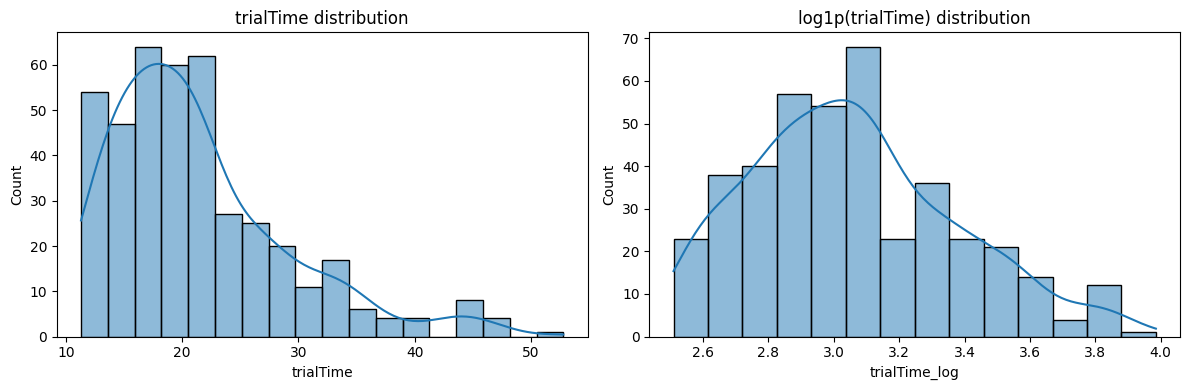

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

target_raw = clean_df["trialTime"].dropna()
skew_val = target_raw.skew()
log_transform = skew_val > 1.0

target_col_name = "trialTime"
if log_transform:
    target_col_name = "trialTime_log"
    clean_df[target_col_name] = np.log1p(clean_df["trialTime"])
    print(f"Target skewness = {skew_val:.2f}; applying log1p -> column '{target_col_name}'.")
else:
    print(f"Target skewness = {skew_val:.2f}; no log transform applied.")

fig, axes = plt.subplots(1, 2 if log_transform else 1, figsize=(12, 4))
axes = axes if isinstance(axes, (list, np.ndarray)) else [axes]

sns.histplot(target_raw, kde=True, ax=axes[0])
axes[0].set_title("trialTime distribution")
axes[0].set_xlabel("trialTime")

if log_transform:
    sns.histplot(clean_df[target_col_name].dropna(), kde=True, ax=axes[1])
    axes[1].set_title("log1p(trialTime) distribution")
    axes[1].set_xlabel(target_col_name)

plt.tight_layout()
plt.show()


In [52]:
# Random split baseline (mixed techniques)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

mixed_df = clean_df.dropna(subset=[target_col_name]).copy()

# Remove target, id, technique, and any time-related columns to avoid leakage
mixed_time_cols = [c for c in mixed_df.columns if "time" in c.lower()]
mixed_exclude_cols = set([target_col_name, "iD", "technique"] + mixed_time_cols)
mixed_base_features = [c for c in mixed_df.columns if c not in mixed_exclude_cols]

usable_cols = [c for c in mixed_base_features if not mixed_df[c].isna().all()]
X = mixed_df[usable_cols].copy()
y = mixed_df[target_col_name]

# Stratify the train/test split with binned target to preserve distribution
bins = pd.qcut(y, q=min(5, len(y)), duplicates='drop').astype(str)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=bins
)

numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

preprocessor = ColumnTransformer(
    [
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), numeric_cols),
        (
            "cat",
            Pipeline(
                [
                    ("imputer", SimpleImputer(strategy="most_frequent")),
                    ("onehot", OneHotEncoder(handle_unknown="ignore")),
                ]
            ),
            categorical_cols,
        ),
    ]
)

rf_param_grid = {
    "rf__n_estimators": [200, 400, 800],
    "rf__max_depth": [None, 10, 20],
    "rf__min_samples_leaf": [1, 2, 4],
    "rf__max_features": ["sqrt", "log2", None],
}

rf = RandomForestRegressor(random_state=42)
model = Pipeline([("prep", preprocessor), ("rf", rf)])
cv_splits = get_stratified_cv(y_train, n_splits=3)
search = GridSearchCV(model, param_grid=rf_param_grid, cv=cv_splits, n_jobs=-1)
search.fit(X_train, y_train)
test_preds = search.predict(X_test)

baseline_r2 = r2_score(y_test, test_preds)
baseline_mae = mean_absolute_error(y_test, test_preds)

print("Random split baseline (mixed techniques):")
print(f"Test R2: {baseline_r2:.3f}, Test MAE: {baseline_mae:.3f}")
print("Best params:", search.best_params_)

# fi_df = extract_feature_importances(search, "rf")
# if fi_df is not None:
#     print("Top RF feature importances (mixed split):")
#     display(fi_df.head(20))


Random split baseline (mixed techniques):
Test R2: 0.400, Test MAE: 0.196
Best params: {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 4, 'rf__n_estimators': 200}
